In [1]:
# Copyright(C) Facebook, Inc. and its affiliates. All Rights Reserved.

import time
from typing import Dict, List, Optional, Tuple

import beanmachine.ppl as bm
import torch
import torch.distributions as dist
import torch.optim as optim
from torch import Tensor, tensor

from pplbench.PPLBench import PPLBenchPPL
import beanmachine.ppl.experimental.inference_compilation.ic_infer as ic_infer

class HiddenMarkovModel(object):
    def __init__(
        self,
        N: int,
        K: int,
        observations: List,
        num_samples: int,
        concentration: float,
        mu_loc: float,
        mu_scale: float,
        sigma_shape: float,
        sigma_rate: float,
        model: Optional[Tensor],
        inference_type: Optional[str],
        ic_args: Optional[dict],
    ) -> None:
        self.observations = observations
        self.N = N
        self.K = K
        self.num_samples = num_samples

        self.concentration: float = concentration
        self.mu_loc = mu_loc
        self.mu_scale = mu_scale
        self.sigma_shape = sigma_shape
        self.sigma_rate = sigma_rate
        self.model = model
        self.inference_type = inference_type
        if self.inference_type == "ic":
            self.ic = ic_infer.ICInference().compile(
                [self.X(0)] + [
                    self.Y(n) for n in range(self.N)
                ] + (([
                    self.Theta(k) for k in range(self.K)
                ] + [
                    self.Mu(k) for k in range(self.K)
                ] + [
                    self.Sigma(k) for k in range(self.K)
                ]) if self.model else []),
                num_worlds=ic_args["num_worlds"],
                optimizer_func=lambda p: optim.Adam(p, lr=ic_args["lr"], weight_decay=ic_args["wd"])
            )

    @bm.random_variable
    def Theta(self, k):
        return dist.Dirichlet(torch.ones(self.K) * self.concentration / self.K)

    @bm.random_variable
    def Mu(self, k):
        return dist.Normal(self.mu_loc, self.mu_scale)

    @bm.random_variable
    def Sigma(self, k):
        return dist.Gamma(self.sigma_shape, self.sigma_rate)

    # Hidden states
    @bm.random_variable
    def X(self, n: int):
        if n == 0:
            return dist.Categorical(tensor([1.0] + [0.0] * (self.K - 1)))
        else:
            return dist.Categorical(self.Theta(self.X(n - 1).item()))

    # Noisy observations/emissions
    @bm.random_variable
    def Y(self, n: int):
        return dist.Normal(self.Mu(self.X(n).item()), self.Sigma(self.X(n).item()))

    def infer(self):
        queries = [self.X(self.N - 1)]
        if not self.model:
            queries += (
                [self.Theta(k) for k in range(self.K)]
                + [self.Mu(k) for k in range(self.K)]
                + [self.Sigma(k) for k in range(self.K)]
            )

        observations_dict = {self.Y(n): self.observations[n] for n in range(self.N)}
        observations_dict.update({self.X(0): tensor(0.0)})
        if self.model:
            observations_dict.update(
                {self.Theta(k): self.model["theta"][k] for k in range(self.K)}
            )
            observations_dict.update(
                {self.Mu(k): self.model["mus"][k] for k in range(self.K)}
            )
            observations_dict.update(
                {self.Sigma(k): self.model["sigmas"][k] for k in range(self.K)}
            )
        observations_dict = dict(observations_dict)

        start_time = time.time()
        if self.inference_type == "mcmc":
            mh = bm.CompositionalInference()
            inferred = mh.infer(queries, observations_dict, self.num_samples, num_chains=1)
        elif self.inference_type == "mcmc-uniform":
            mh = bm.SingleSiteUniformMetropolisHastings()
            inferred = mh.infer(queries, observations_dict, self.num_samples, num_chains=1)
        elif self.inference_type == "ic":
            inferred = self.ic.infer(
                queries=queries,
                observations=observations_dict,
                num_samples=self.num_samples,
                num_chains=1)
        elapsed_time_sample_beanmachine = time.time() - start_time

        if self.model:
            samples = inferred.get_chain()[self.X(self.N - 1)].detach().numpy()

        else:
            # Return as a tuple of: thetas, mus, sigmas, xNs
            samples = (
                [
                    inferred.get_chain()[self.Theta(k)].detach().numpy()
                    for k in range(self.K)
                ],
                [
                    inferred.get_chain()[self.Mu(k)].detach().numpy()
                    for k in range(self.K)
                ],
                [
                    inferred.get_chain()[self.Sigma(k)].detach().numpy()
                    for k in range(self.K)
                ],
                inferred.get_chain()[self.X(self.N - 1)].detach().numpy(),
            )
        return (samples, elapsed_time_sample_beanmachine)


class HiddenMarkov(PPLBenchPPL):
    def obtain_posterior(
        self, data_train: List, args_dict: Dict, model: Optional[Tensor]
    ) -> Tuple[List, Dict]:
        """
        Beanmachine impmementation of HMM prediction.

        :param data_train:
        :param args_dict: a dict of model arguments
        :returns: samples_beanmachine(dict): posterior samples of all parameters
        :returns: timing_info(dict): compile_time, inference_time
        """
        concentration, mu_loc, mu_scale, sigma_shape, sigma_rate, observe_model = list(
            map(float, args_dict["model_args"])
        )
        N = int(args_dict["n"])
        K = int(args_dict["k"])
        num_samples = int(args_dict["num_samples"])
        if not observe_model:
            model = None

        start_time = time.time()
        # hmm = HiddenMarkovModel(N, K, theta, sigma, data_train, num_samples)
        hmm = HiddenMarkovModel(
            N,
            K,
            data_train,
            num_samples,
            concentration,
            mu_loc,
            mu_scale,
            sigma_shape,
            sigma_rate,
            model,
            inference_type=args_dict["inference_type"],
            ic_args=args_dict["ic"],
        )
        elapsed_time_compile_beanmachine = time.time() - start_time

        samples, elapsed_time_sample_beanmachine = hmm.infer()

        # repackage samples into shape required by PPLBench
        xn1str = "X[" + str(N - 1) + "]"
        if observe_model:
            samples_formatted = [{xn1str: xn1} for xn1 in samples]

        else:
            thetas, mus, sigmas, xn1s = samples
            # Want to swap the way these are ordered, so we can iterate through.
            thetas = [[thetasK[i] for thetasK in thetas] for i in range(num_samples)]
            mus = [[musK[i] for musK in mus] for i in range(num_samples)]
            sigmas = [[sigmasK[i] for sigmasK in sigmas] for i in range(num_samples)]
            # Now, e.g., thetas[i] gives the 'i'th
            # MCMC sample of theta[0 .. K] as a list

            samples_formatted = [
                {"theta": theta, "mus": mu, "sigmas": sigma, xn1str: xn1}
                for theta, mu, sigma, xn1 in zip(thetas, mus, sigmas, xn1s)
            ]

        timing_info = {
            "compile_time": elapsed_time_compile_beanmachine,
            "inference_time": elapsed_time_sample_beanmachine,
        }
        return (samples_formatted, timing_info)


In [2]:
timing_infos = {}
posterior_samples = {}
posterior_predictive = {}

In [3]:
import time
import numpy as np
import pandas as pd

import torch
import torch.distributions as dist
from torch import tensor

import pplbench.models.hidden_markov_model as model

_model = model

args_dict = model.get_defaults()
args_dict["trials"] = 5
args_dict["plot_data_size"] = 100
args_dict["num_samples"] = 100
args_dict["num_samples_beanmachine_vectorized"] = 100
#args_dict["inference_type"] = "ic"
args_dict["inference_type"] = "mcmc"
args_dict["ic"] = None

model_instance = model.generate_model(args_dict)
generated_data = model.generate_data(args_dict=args_dict, model=model_instance)
ppl_instance = HiddenMarkov()

ppl = 'BM_NMC'
timing_infos[ppl] = [None] * int(args_dict["trials"])
posterior_samples[ppl] = [None] * int(args_dict["trials"])
posterior_predictive[ppl] = [None] * int(args_dict["trials"])
ic = None
# start trial loop
for i in range(int(args_dict["trials"])):
    print("Starting trial", i + 1, "of", args_dict["trials"])
    
    # obtain posterior samples and timing info
    data_train=generated_data["data_train"]
    (
        posterior_samples[ppl][i],
        timing_infos[ppl][i],
    ) = ppl_instance.obtain_posterior(data_train, args_dict,model=model_instance)
    
    # compute posterior predictive
    posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
        samples=posterior_samples[ppl][i].copy(),
        data_test=generated_data["data_test"],
        model=model_instance,
    )
    print(
        f"Trial {i + 1} "
        f'complete in {timing_infos[ppl][i]["inference_time"]} '
        "seconds.\n Statistics of  posterior predictive\n mean:"
        f"{np.array(posterior_predictive[ppl][i]).mean()}"
        f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
    )

Generating data
Starting trial 1 of 5



Trial 1 complete in 7.247365236282349 seconds.
 Statistics of  posterior predictive
 mean:0.6439247727394104
 var: 3.552713678800501e-15
Starting trial 2 of 5



Trial 2 complete in 7.222901821136475 seconds.
 Statistics of  posterior predictive
 mean:0.6439247727394104
 var: 3.552713678800501e-15
Starting trial 3 of 5



Trial 3 complete in 7.170017242431641 seconds.
 Statistics of  posterior predictive
 mean:0.6439247727394104
 var: 3.552713678800501e-15
Starting trial 4 of 5



Trial 4 complete in 7.178408861160278 seconds.
 Statistics of  posterior predictive
 mean:0.6095283627510071
 var: 0.1171281561255455
Starting trial 5 of 5



Trial 5 complete in 7.1932361125946045 seconds.
 Statistics of  posterior predictive
 mean:0.6439247727394104
 var: 3.552713678800501e-15


In [4]:
import time
import numpy as np
import pandas as pd

import torch
import torch.distributions as dist
from torch import tensor

import pplbench.models.hidden_markov_model as model

_model = model

args_dict = model.get_defaults()
args_dict["trials"] = 5
args_dict["plot_data_size"] = 100
args_dict["num_samples"] = 100
args_dict["num_samples_beanmachine_vectorized"] = 100
#args_dict["inference_type"] = "ic"
args_dict["inference_type"] = "mcmc-uniform"
args_dict["ic"] = None

model_instance = model.generate_model(args_dict)
generated_data = model.generate_data(args_dict=args_dict, model=model_instance)
ppl_instance = HiddenMarkov()

ppl = 'BM_uniform'
timing_infos[ppl] = [None] * int(args_dict["trials"])
posterior_samples[ppl] = [None] * int(args_dict["trials"])
posterior_predictive[ppl] = [None] * int(args_dict["trials"])
ic = None
# start trial loop
for i in range(int(args_dict["trials"])):
    print("Starting trial", i + 1, "of", args_dict["trials"])
    
    # obtain posterior samples and timing info
    data_train=generated_data["data_train"]
    (
        posterior_samples[ppl][i],
        timing_infos[ppl][i],
    ) = ppl_instance.obtain_posterior(data_train, args_dict,model=model_instance)
    
    # compute posterior predictive
    posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
        samples=posterior_samples[ppl][i].copy(),
        data_test=generated_data["data_test"],
        model=model_instance,
    )
    print(
        f"Trial {i + 1} "
        f'complete in {timing_infos[ppl][i]["inference_time"]} '
        "seconds.\n Statistics of  posterior predictive\n mean:"
        f"{np.array(posterior_predictive[ppl][i]).mean()}"
        f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
    )

Generating data
Starting trial 1 of 5



Trial 1 complete in 7.372642755508423 seconds.
 Statistics of  posterior predictive
 mean:-1.946231484413147
 var: 1.4210854715202004e-14
Starting trial 2 of 5



Trial 2 complete in 7.340271711349487 seconds.
 Statistics of  posterior predictive
 mean:-2.017906665802002
 var: 5.684341886080802e-14
Starting trial 3 of 5



Trial 3 complete in 7.313391447067261 seconds.
 Statistics of  posterior predictive
 mean:-2.1477413177490234
 var: 0.03752060607075691
Starting trial 4 of 5



Trial 4 complete in 7.1349804401397705 seconds.
 Statistics of  posterior predictive
 mean:-2.017906665802002
 var: 5.684341886080802e-14
Starting trial 5 of 5



Trial 5 complete in 7.3141770362854 seconds.
 Statistics of  posterior predictive
 mean:-2.017906665802002
 var: 5.684341886080802e-14


In [5]:
import time
import numpy as np
import pandas as pd

import torch
import torch.distributions as dist
from torch import tensor

import pplbench.models.hidden_markov_model as model

_model = model

args_dict = model.get_defaults()
args_dict["trials"] = 5
args_dict["plot_data_size"] = 100
args_dict["num_samples"] = 100
args_dict["num_samples_beanmachine_vectorized"] = 100
#args_dict["inference_type"] = "mcmc"
args_dict["inference_type"] = "ic"
args_dict["ic"] = {
    "num_worlds": int(1e2),
    "lr": 1e-2,
    "wd": 1e-3,
}


model_instance = model.generate_model(args_dict)
generated_data = model.generate_data(args_dict=args_dict, model=model_instance)
ppl_instance = HiddenMarkov()

ppl = 'BM_IC'
timing_infos[ppl] = [None] * int(args_dict["trials"])
posterior_samples[ppl] = [None] * int(args_dict["trials"])
posterior_predictive[ppl] = [None] * int(args_dict["trials"])
ic = None
# start trial loop
for i in range(int(args_dict["trials"])):
    print("Starting trial", i + 1, "of", args_dict["trials"])
    
    # obtain posterior samples and timing info
    data_train=generated_data["data_train"]
    (
        posterior_samples[ppl][i],
        timing_infos[ppl][i],
    ) = ppl_instance.obtain_posterior(data_train, args_dict, model=model_instance)
    
    # compute posterior predictive
    posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
        samples=posterior_samples[ppl][i].copy(),
        data_test=generated_data["data_test"],
        model=model_instance,
    )
    print(
        f"Trial {i + 1} "
        f'complete in {timing_infos[ppl][i]["inference_time"]} '
        "seconds.\n Statistics of  posterior predictive\n mean:"
        f"{np.array(posterior_predictive[ppl][i]).mean()}"
        f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
    )

Generating data
Starting trial 1 of 5



Training Results - Epoch: 1  Avg loss: 73.80
Validation Results - Epoch: 1  Avg loss: 36.32
EPOCH_COMPLETED took 284.6221568584442 seconds
COMPLETED took 329.635769367218 seconds



Trial 1 complete in 17.28995943069458 seconds.
 Statistics of  posterior predictive
 mean:-6.064169406890869
 var: 9.094947017729282e-13
Starting trial 2 of 5



Training Results - Epoch: 1  Avg loss: 30.70
Validation Results - Epoch: 1  Avg loss: 16.71
EPOCH_COMPLETED took 289.7421112060547 seconds
COMPLETED took 336.20754837989807 seconds



Trial 2 complete in 20.93644428253174 seconds.
 Statistics of  posterior predictive
 mean:-1.7265493869781494
 var: 0.1900499314069748
Starting trial 3 of 5



Training Results - Epoch: 1  Avg loss: 26.12
Validation Results - Epoch: 1  Avg loss: 21.10
EPOCH_COMPLETED took 315.9466359615326 seconds
COMPLETED took 362.14820861816406 seconds



Trial 3 complete in 21.294909477233887 seconds.
 Statistics of  posterior predictive
 mean:-6.064169406890869
 var: 9.094947017729282e-13
Starting trial 4 of 5



Training Results - Epoch: 1  Avg loss: 18.93
Validation Results - Epoch: 1  Avg loss: 16.53
EPOCH_COMPLETED took 312.8978953361511 seconds
COMPLETED took 367.19911766052246 seconds



Trial 4 complete in 20.737121105194092 seconds.
 Statistics of  posterior predictive
 mean:-6.064169406890869
 var: 9.094947017729282e-13
Starting trial 5 of 5



Training Results - Epoch: 1  Avg loss: 24.62
Validation Results - Epoch: 1  Avg loss: 77.65
EPOCH_COMPLETED took 352.09198570251465 seconds
COMPLETED took 412.70882868766785 seconds



Trial 5 complete in 21.782921314239502 seconds.
 Statistics of  posterior predictive
 mean:-6.064169406890869
 var: 9.094947017729282e-13


In [11]:
import PPLBench

posterior_samples_subset = PPLBench.get_sample_subset(posterior_predictive, args_dict)
trial_info = PPLBench.compute_trial_statistics(posterior_predictive)
trial_info = PPLBench.combine_dictionaries(trial_info, timing_infos)
summary_info = PPLBench.compute_summary_statistics(
    posterior_predictive, timing_infos, args_dict
)


In [12]:
trial_info

{'BM_NMC': {0: {'n_eff': 0.0,
   'num_unique': 1,
   'compile_time': 8.106231689453125e-06,
   'inference_time': 7.247365236282349},
  1: {'n_eff': 0.0,
   'num_unique': 1,
   'compile_time': 7.867813110351562e-06,
   'inference_time': 7.222901821136475},
  2: {'n_eff': 0.0,
   'num_unique': 1,
   'compile_time': 5.245208740234375e-06,
   'inference_time': 7.170017242431641},
  3: {'n_eff': 102.10437774658203,
   'num_unique': 2,
   'compile_time': 5.0067901611328125e-06,
   'inference_time': 7.178408861160278},
  4: {'n_eff': 0.0,
   'num_unique': 1,
   'compile_time': 5.245208740234375e-06,
   'inference_time': 7.1932361125946045}},
 'BM_uniform': {0: {'n_eff': nan,
   'num_unique': 1,
   'compile_time': 6.67572021484375e-06,
   'inference_time': 7.372642755508423},
  1: {'n_eff': 0.0,
   'num_unique': 1,
   'compile_time': 5.0067901611328125e-06,
   'inference_time': 7.340271711349487},
  2: {'n_eff': 6.973954677581787,
   'num_unique': 2,
   'compile_time': 5.4836273193359375e-06,


In [13]:
summary_info

{'BM_NMC': {'r_hat': 1.0,
  'n_eff': 510.41455078125,
  'n_eff/time': 14.17348531658242},
 'BM_uniform': {'r_hat': 1.4696024656295776,
  'n_eff': 6.156506538391113,
  'n_eff/time': 0.1687848752600037},
 'BM_IC': {'r_hat': 9.386752128601074,
  'n_eff': 2.539161443710327,
  'n_eff/time': 0.024883650638840918}}

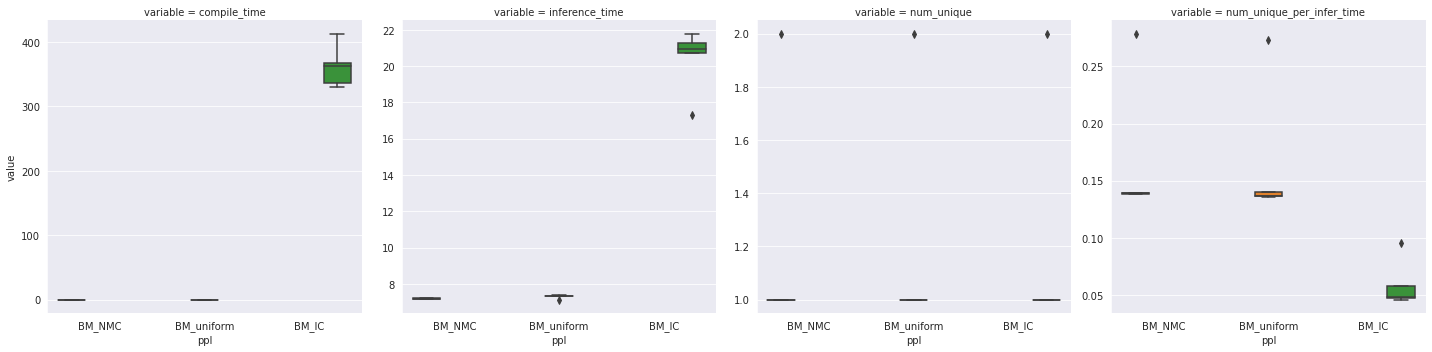

In [14]:
df = pd.DataFrame()
for ppl in trial_info:
    trials = pd.DataFrame(trial_info[ppl]).T
    trials["ppl"] = ppl
    df = df.append(trials)
df["num_unique_per_infer_time"] = df["num_unique"] / df["inference_time"]
    
import seaborn as sns
sns.set_style("darkgrid")

sns.catplot(data=df.melt(
    id_vars=["ppl"],
    value_vars=["compile_time", "inference_time", "num_unique", "num_unique_per_infer_time"],
), col="variable", x="ppl", y="value", hue="ppl", sharey=False, kind="box")    

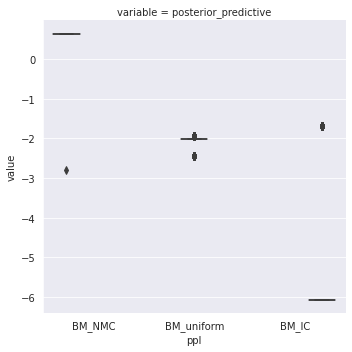

In [15]:
df = pd.DataFrame([
        {
            "ppl": ppl,
            "posterior_predictive": trial_val
        } 
    for ppl in posterior_predictive
    for trial in posterior_predictive[ppl]
    for trial_val in trial
])
sns.catplot(data=df.melt(
    id_vars=["ppl"],
    value_vars=["posterior_predictive"],
), col="variable", hue="ppl", x="ppl", y="value", sharey=False, kind="box")